In [1]:
import pandas as pd
import numpy as np
import datetime

p = pd.read_csv('DelayedFlights.csv')
print(p.columns)
print()
p['CRSDepTime'] = p['CRSDepTime'].astype(str).str.zfill(4)
p['Hour'] = p['CRSDepTime'].str.slice(0,2)
p['Minute'] = p['CRSDepTime'].str.slice(2,4)

p.rename(columns = {'DayofMonth':'Day'}, inplace = True)

p['SCHDep'] = pd.to_datetime(p[['Year', 'Month', 'Day', 'Hour','Minute']], format="%Y/%m/%d %H:%M")

def format_hora(par):
    if pd.isnull(par):
        return np.nan
    else:
        if par == 2400: par = 0
        par = "{0:04d}".format(int(par))
        hora = datetime.time(hour = int(par[0:2]), minute = int(par[2:4]))
        return hora
      
p['DepTime'] = p['DepTime'].apply(format_hora)
p['CRSArrTime'] = p['CRSArrTime'].apply(format_hora)
p['ArrTime'] = p['ArrTime'].apply(format_hora)

p = p[['UniqueCarrier', 'Origin', 'Dest',
        'SCHDep', 'DayOfWeek', 'DepTime', 'DepDelay',
        'CRSArrTime', 'ArrTime', 'ArrDelay',
        'CRSElapsedTime', 'ActualElapsedTime']]

#99% de dades omplertes per la qual cosa s'opta per no fer omplement de dades buides
p2 = p.dropna(axis=0)

# treure valors unics del Arr Delay perque dòna error al fer el split
p3 = p2.groupby('ArrDelay').filter(lambda x : len(x)>1)

# passar Origin i Dest a nombres i categories
p3['Origin'].replace(list(set(p3['Origin'])), list(range(len(set(p3['Origin'])))), inplace = True)

p3['Dest'].replace(list(set(p3['Dest'])), list(range(len(set(p3['Dest'])))), inplace = True)

p3[['DayOfWeek', 'Origin','Dest']] = p3[['DayOfWeek', 'Origin','Dest']].astype('category')

# canviar float 64 a 32 perquè s'excedeix la memoria al fer dummies
p3[['DepDelay', 'ArrDelay','CRSElapsedTime', 'ActualElapsedTime']] = p3[['DepDelay', 'ArrDelay','CRSElapsedTime', 'ActualElapsedTime']].astype('float32')
p3.info()
print()

p3.describe(exclude=['datetime']).transpose()

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928155 entries, 0 to 1936757
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   UniqueCarrier      object        
 1   Origin             category      
 2   Dest               category      
 3   SCHDep             datetime64[ns]
 4   DayOfWeek          category      
 5   DepTime            object        
 6   DepDelay           float32       
 7   CRSArrTime         object        
 8   ArrTime            object

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UniqueCarrier,1928155,20,WN,376199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin,1928155.0,303.0,198.0,131212.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,1928155.0,302.0,111.0,108240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,1928155.0,7.0,5.0,321931.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepTime,1928155,1438,18:00:00,3176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepDelay,1928155.0,NaN,NaN,NaN,42.987209,52.229286,6.0,12.0,24.0,53.0,1403.0
CRSArrTime,1928155,1361,19:30:00,9145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrTime,1928155,1440,21:00:00,2981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,1928155.0,NaN,NaN,NaN,42.094742,55.79892,-66.0,9.0,24.0,56.0,1395.0
CRSElapsedTime,1928155.0,NaN,NaN,NaN,134.193298,71.228745,-21.0,82.0,116.0,165.0,660.0


In [2]:
#divisió de les dades en training i test

from sklearn.model_selection import train_test_split

print('vols sense retràs a l\'arribada de totes les dades: ',len(p3[p3['ArrDelay'] <= 0]), 'equivalent a un', round(len(p3[p3['ArrDelay'] <= 0]) * 100 / len(p3['ArrDelay']), 2) , '%')
print()
print('vols amb 24 minuts o menys de retràs a la sortida de totes les dades: ',len(p3[p3['DepDelay'] <= 24]), 'equivalent a un', round(len(p3[p3['DepDelay'] <= 24]) * 100 / len(p3['DepDelay']), 2) , '%')
print()

y = p3.pop('ArrDelay')
X = p3

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27, train_size=0.7, stratify=y)
X_train
print("Totes les dades predictores:", X.shape, "i  diana", y.shape[0])
print("Dades pels predictors del subconjunt training:", X_train.shape, " i diana", y_train.shape[0])
print("Dades pels predictores del subconjunt test:", X_test.shape, " i diana", y_test.shape[0])
print()

print('vols sense retràs a l\'arribada al subconjunt training: ', round(len(y_train[y_train <= 0]) * 100 / len(y_train), 2), '%')
print('vols sense retràs a l\'arribada al subconjunt test: ', round(len(y_test[y_test <= 0]) * 100 / len(y_test), 2), '%')
print()

print('vols amb 24 minuts o menys de retràs a l\'arribada al subconjunt training: ', round(len(X_train[X_train['DepDelay'] <= 24]) * 100 / len(X_train), 2), '%')
print('vols amb 24 minuts o menys de retràs a l\'arribada al subconjunt test: ', round(len(X_test[X_test['DepDelay'] <= 24]) * 100 / len(X_test), 2), '%')

vols sense retràs a l'arribada de totes les dades:  204948 equivalent a un 10.63 %

vols amb 24 minuts o menys de retràs a la sortida de totes les dades:  970323 equivalent a un 50.32 %

Totes les dades predictores: (1928155, 11) i  diana 1928155
Dades pels predictors del subconjunt training: (1349708, 11)  i diana 1349708
Dades pels predictores del subconjunt test: (578447, 11)  i diana 578447

vols sense retràs a l'arribada al subconjunt training:  10.63 %
vols sense retràs a l'arribada al subconjunt test:  10.63 %

vols amb 24 minuts o menys de retràs a l'arribada al subconjunt training:  50.32 %
vols amb 24 minuts o menys de retràs a l'arribada al subconjunt test:  50.33 %


In [3]:
#%config InteractiveShell.ast_node_interactivity = 'all' #no funciona

print('Resum estadístic del training')
X_train.describe(exclude=['datetime']).transpose()


Resum estadístic del training


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UniqueCarrier,1349708,20,WN,263597,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin,1349708.0,302.0,198.0,91797.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,1349708.0,302.0,111.0,75789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,1349708.0,7.0,5.0,225399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepTime,1349708,1434,18:00:00,2181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepDelay,1349708.0,NaN,NaN,NaN,42.968941,52.043674,6.0,12.0,24.0,53.0,1403.0
CRSArrTime,1349708,1360,19:30:00,6329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrTime,1349708,1440,21:00:00,2092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRSElapsedTime,1349708.0,NaN,NaN,NaN,134.158997,71.233482,-21.0,82.0,116.0,165.0,660.0
ActualElapsedTime,1349708.0,NaN,NaN,NaN,133.270325,72.066025,14.0,80.0,116.0,165.0,790.0


In [4]:
y_train.describe()

count    1.349708e+06
mean     4.208024e+01
std      5.563818e+01
min     -6.600000e+01
25%      9.000000e+00
50%      2.400000e+01
75%      5.600000e+01
max      1.395000e+03
Name: ArrDelay, dtype: float64

In [5]:
print('Resum estadístic del test')
X_test.describe(exclude=['datetime']).transpose()

Resum estadístic del test


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UniqueCarrier,578447,20,WN,112602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin,578447.0,300.0,198.0,39415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,578447.0,300.0,111.0,32451.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,578447.0,7.0,5.0,96532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepTime,578447,1403,18:00:00,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepDelay,578447.0,NaN,NaN,NaN,43.029797,52.659859,6.0,12.0,24.0,53.0,1401.0
CRSArrTime,578447,1330,19:30:00,2816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrTime,578447,1440,21:00:00,889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRSElapsedTime,578447.0,NaN,NaN,NaN,134.273239,71.217697,15.0,82.0,117.0,165.0,660.0
ActualElapsedTime,578447.0,NaN,NaN,NaN,133.372101,72.02124,15.0,80.0,116.0,165.0,750.0


In [6]:
y_test.describe()

count    578447.000000
mean         42.128666
std          56.172226
min         -66.000000
25%           9.000000
50%          24.000000
75%          56.000000
max        1395.000000
Name: ArrDelay, dtype: float64

In [7]:
# dummy variables
dmList1 = pd.get_dummies(X_train['UniqueCarrier'])
X_train = pd.concat([X_train, dmList1], axis = 1)
data_train=X_train.drop(labels = ['UniqueCarrier'], axis=1)

dmList1 = pd.get_dummies(X_test['UniqueCarrier'])
X_test = pd.concat([X_test, dmList1], axis = 1)
data_test=X_test.drop(labels = ['UniqueCarrier'], axis=1)


#normalitzar tenint en compte els outliers
from sklearn.preprocessing import RobustScaler

trans = RobustScaler(quantile_range=(30, 70), with_centering=False, with_scaling=True)
data_train[['DepDelay', 'CRSElapsedTime', 'ActualElapsedTime']] = trans.fit_transform(data_train[['DepDelay', 'CRSElapsedTime', 'ActualElapsedTime']])
data_test[['DepDelay', 'CRSElapsedTime', 'ActualElapsedTime']] = trans.fit_transform(data_test[['DepDelay', 'CRSElapsedTime', 'ActualElapsedTime']])


In [8]:
# transformació polinomial per mirar la interacció entre Origen del vol i dia de la setmana
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
data_train[['Origin', 'DayOfWeek']] = poly.fit_transform(data_train[['Origin', 'DayOfWeek']])
data_test[['Origin', 'DayOfWeek']] = poly.fit_transform(data_test[['Origin', 'DayOfWeek']])

#no entenc perquè surt aquest error

ValueError: Columns must be same length as key

In [9]:
print('Resum estadístic del training transformat')
data_train.describe(exclude=['datetime']).transpose()

Resum estadístic del training transformat


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Origin,1349708.0,302.0,198.0,91797.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,1349708.0,302.0,111.0,75789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,1349708.0,7.0,5.0,225399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepTime,1349708,1434,18:00:00,2181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepDelay,1349708.0,NaN,NaN,NaN,1.386095,1.678828,0.193548,0.387097,0.774194,1.709677,45.258064
CRSArrTime,1349708,1360,19:30:00,6329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrTime,1349708,1440,21:00:00,2092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRSElapsedTime,1349708.0,NaN,NaN,NaN,1.972927,1.047551,-0.308824,1.205882,1.705882,2.426471,9.705882
ActualElapsedTime,1349708.0,NaN,NaN,NaN,1.989109,1.075612,0.208955,1.19403,1.731343,2.462687,11.791045
9E,1349708.0,NaN,NaN,NaN,0.02675,0.161353,0.0,0.0,0.0,0.0,1.0


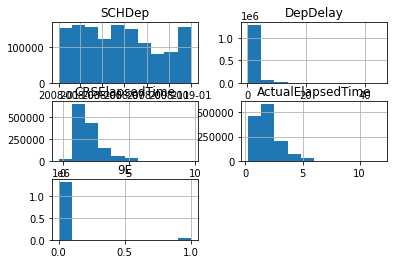

In [10]:
# histogrames fins la primera variable dummy

import matplotlib.pyplot as plt
data_train.iloc[:, 0:11].hist()
plt.show()